In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold 
from sklearn import svm
from sklearn.metrics import mean_squared_error

In [2]:
dataset = pd.read_csv("sgemm_product.csv")
dataset.shape

(241600, 18)

In [3]:
dataset['AverageRun'] = dataset[['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)']].mean(axis = 1)

In [4]:
dataset['AverageRun'].describe()

count    241600.000000
mean        217.571953
std         368.750161
min          13.317500
25%          40.667500
50%          69.790000
75%         228.387500
max        3341.507500
Name: AverageRun, dtype: float64

In [5]:
def scale_columns(dataframe):
    dfSubmean = dataframe - dataframe.mean()
    return dfSubmean / dataframe.std()

In [6]:
x = scale_columns(dataset[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN']])
x[['STRM','STRN','SA','SB']] = dataset[['STRM','STRN','SA','SB']]
x.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB
0,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,0,0,0
1,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,0,0,1
2,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,0,1,0
3,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,0,1,1
4,-1.516754,-1.516754,-1.210995,-0.753892,-0.753892,-0.998052,-0.998052,-0.999998,-0.741447,-0.741447,0,1,0,0


In [7]:
dataset['AverageRun'].median()

69.79

In [8]:
def isGreaterThanMedian(x, median):
    if x > median:
        return 1
    return 0

In [9]:
median = dataset['AverageRun'].median()
target = dataset['AverageRun'].apply(isGreaterThanMedian, args = (median,))

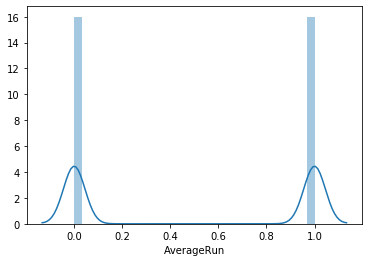

In [10]:
sns.distplot(target)

In [12]:
test_size_list = [0.99,0.8,0.7,0.5,0.4,0.3,0.2]
training_set_size=[]
train_mse=[]
test_mse=[]
for test_size in test_size_list:
    X_train, X_test, y_train, y_test = train_test_split(x, target, test_size= test_size, random_state=123)
    linear_svc = svm.SVC(kernel='linear')
    linear_svc.fit(X_train,y_train)
    y_pred = linear_svc.predict(X_train)
    train_mse.append(mean_squared_error(y_train, y_pred))
    y_pred = linear_svc.predict(X_test)
    test_mse.append(mean_squared_error(y_test, y_pred))
    training_set_size.append(len(X_train))

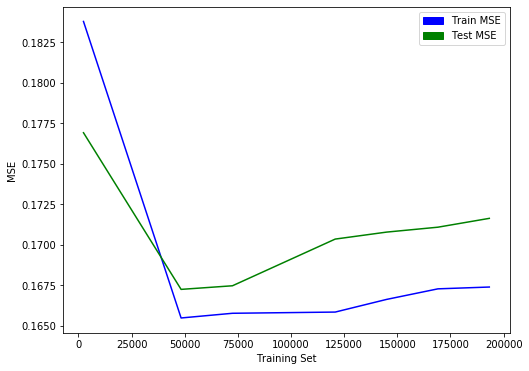

In [13]:
import matplotlib.patches as mpatches
plt.figure(figsize=(8,6))
plt.plot(training_set_size, train_mse, color = "blue") 
plt.plot(training_set_size, test_mse, color = "green") 
plt.xlabel("Training Set") 
plt.ylabel("MSE")
trainlegend = mpatches.Patch(color='blue', label='Train MSE')
testlegend = mpatches.Patch(color='green', label='Test MSE')
plt.legend([trainlegend, testlegend], ['Train MSE', 'Test MSE'])
plt.show() 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, target, test_size= 0.1, random_state=123)
linear_svc = svm.SVC(kernel='linear')
val_acc = []
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    linear_svc.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    val_acc.append(linear_svc.score(X_train.iloc[val_index],y_train.iloc[val_index]))
accuracy = sum(val_acc)/len(val_acc)*100
print("The accuracy of the linear SVM is {0:.2f}%".format(accuracy))

The accuracy of the linear SVM is 83.21%


In [17]:
test_size_list = [0.99,0.75,0.5,0.2]
training_set_size=[]
train_mse=[]
test_mse=[]
for test_size in test_size_list:
    X_train, X_test, y_train, y_test = train_test_split(x, target, test_size= test_size, random_state=123)
    sigmoid_svc = svm.SVC(kernel='sigmoid', gamma = 'auto')
    sigmoid_svc.fit(X_train,y_train)
    y_pred = sigmoid_svc.predict(X_train)
    train_mse.append(mean_squared_error(y_train, y_pred))
    y_pred = sigmoid_svc.predict(X_test)
    test_mse.append(mean_squared_error(y_test, y_pred))
    training_set_size.append(len(X_train))

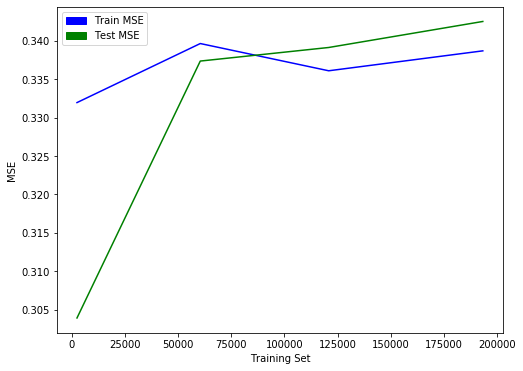

In [18]:
import matplotlib.patches as mpatches
plt.figure(figsize=(8,6))
plt.plot(training_set_size, train_mse, color = "blue") 
plt.plot(training_set_size, test_mse, color = "green") 
plt.xlabel("Training Set") 
plt.ylabel("MSE")
trainlegend = mpatches.Patch(color='blue', label='Train MSE')
testlegend = mpatches.Patch(color='green', label='Test MSE')
plt.legend([trainlegend, testlegend], ['Train MSE', 'Test MSE'])
plt.show()